<h1 style="text-align:center;">Task 4 – Fake vs Real News Classification (Text Data)</h1>

This task classifies news articles as fake or real using the Fake and Real News dataset. The analysis compares classical machine learning models trained on TF-IDF features (Logistic Regression, Naive Bayes, SVM) with a fine-tuned Transformer model (DistilBERT). Explainability analysis using LIME reveals which words influence predictions, and unsupervised topic modeling (LDA) explores thematic patterns in the text data.


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 1</h2>

In [3]:
## step 1, imports and setup.
# here we import all necessary libraries for text processing, classical ML, deep learning NLP, and visualization.

# debugging notes:
# - using transformers library (HuggingFace) for DistilBERT fine-tuning with pytorch backend.
# - nltk and sklearn for text preprocessing, tokenization, and TF-IDF feature extraction.
# - sklearn for classical ML models (Logistic Regression, Naive Bayes, SVM).
# - lime for text explainability (word importance).
# - gensim for LDA topic modeling (unsupervised).
# - matplotlib/seaborn for visualization with dark background theme.
# - all random seeds set for reproducibility.
# - CPU mode (GPU wasnt being recognized).

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# download required nltk data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, roc_auc_score, roc_curve

# pytorch and transformers
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader


# lime for explainability
from lime.lime_text import LimeTextExplainer

# gensim for LDA topic modeling
from gensim import corpora
from gensim.models import LdaModel

# set random seeds
RANDOM_STATE = 67
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_STATE)

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set plot style
plt.style.use('dark_background')

print(f"pytorch version: {torch.__version__}")
print(f"transformers version: {torch.__version__}")
print(f"using device: {device}")


pytorch version: 2.9.1+cpu
transformers version: 2.9.1+cpu
using device: cpu


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 2</h2>

### Data loading and exploration

The Fake and Real News dataset consists of two CSV files containing fake and real news articles. Each article includes a title, text, subject, and date. We load both datasets,
combine them with appropriate labels (0 = fake, 1 = real), and examine the data structure and class distribution.


total articles: 44898
fake articles: 23481
real articles: 21417

columns: ['title', 'text', 'subject', 'date', 'label']

first 3 rows:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   

                date  label  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  

missing values:
title      0
text       0
subject    0
date       0
label      0
dtype: int64

class distribution:
Fake (0): 23481
Real (1): 21417


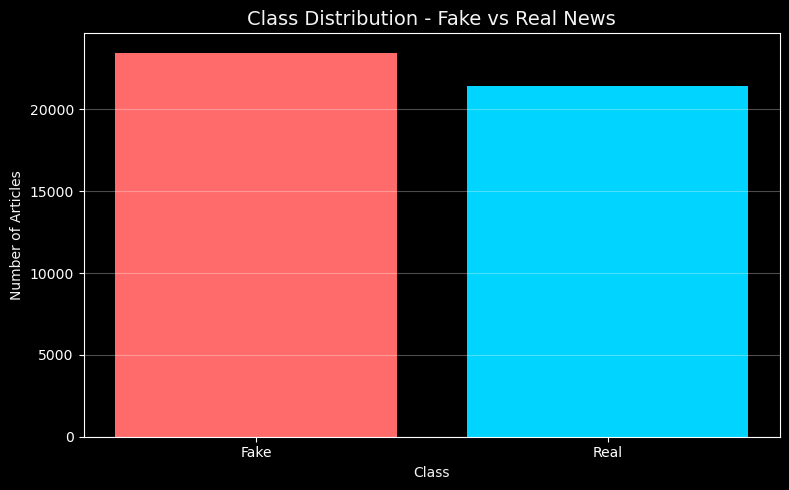


dataset loaded successfully!


In [4]:
## step 2, data loading and exploration.
# here we load fake and real news datasets, combine them, and explore the data structure.

# debugging notes:
# - dataset consists of two separate CSV files: Fake.csv and True.csv.
# - combining both with binary labels (0 = fake, 1 = real).
# - checking for missing values and basic statistics.
# - combining 'title' and 'text' fields for full article content.

# define paths (adjust if your folder structure is different)
DATA_PATH = "data"
FAKE_PATH = os.path.join(DATA_PATH, "Fake.csv")
REAL_PATH = os.path.join(DATA_PATH, "True.csv")

# load datasets
fake_news = pd.read_csv(FAKE_PATH)
real_news = pd.read_csv(REAL_PATH)

# add labels
fake_news['label'] = 0  # fake
real_news['label'] = 1  # real

# combine datasets
df = pd.concat([fake_news, real_news], ignore_index=True)

print(f"total articles: {len(df)}")
print(f"fake articles: {len(fake_news)}")
print(f"real articles: {len(real_news)}")

print(f"\ncolumns: {df.columns.tolist()}")
print(f"\nfirst 3 rows:")
print(df.head(3))

# check for missing values
print(f"\nmissing values:")
print(df.isnull().sum())

# combine title and text for full article content
df['full_text'] = df['title'] + " " + df['text']

# check class distribution
class_counts = df['label'].value_counts()
print(f"\nclass distribution:")
print(f"Fake (0): {class_counts[0]}")
print(f"Real (1): {class_counts[1]}")

# visualize class distribution
plt.figure(figsize=(8, 5))
plt.bar(['Fake', 'Real'], [class_counts[0], class_counts[1]], color=['#ff6b6b', '#00d4ff'])
plt.title("Class Distribution - Fake vs Real News", color='#f4f4f4', fontsize=14)
plt.xlabel("Class", color='#f4f4f4')
plt.ylabel("Number of Articles", color='#f4f4f4')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\ndataset loaded successfully!")


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 3</h2>

### Text preprocessing and exploratory analysis

Raw text data requires cleaning before modeling. We apply lowercase conversion, remove punctuation, URLs, numbers, and stopwords, then tokenize the text. Basic exploratory analysis examines article length distribution and most frequent words in fake vs real news.


cleaning text data (this may take 2-3 minutes)...
text cleaning complete!

article length statistics:
count    44898.000000
mean       234.069112
std        195.996525
min          0.000000
25%        123.000000
50%        208.000000
75%        291.000000
max       4787.000000
Name: text_length, dtype: float64


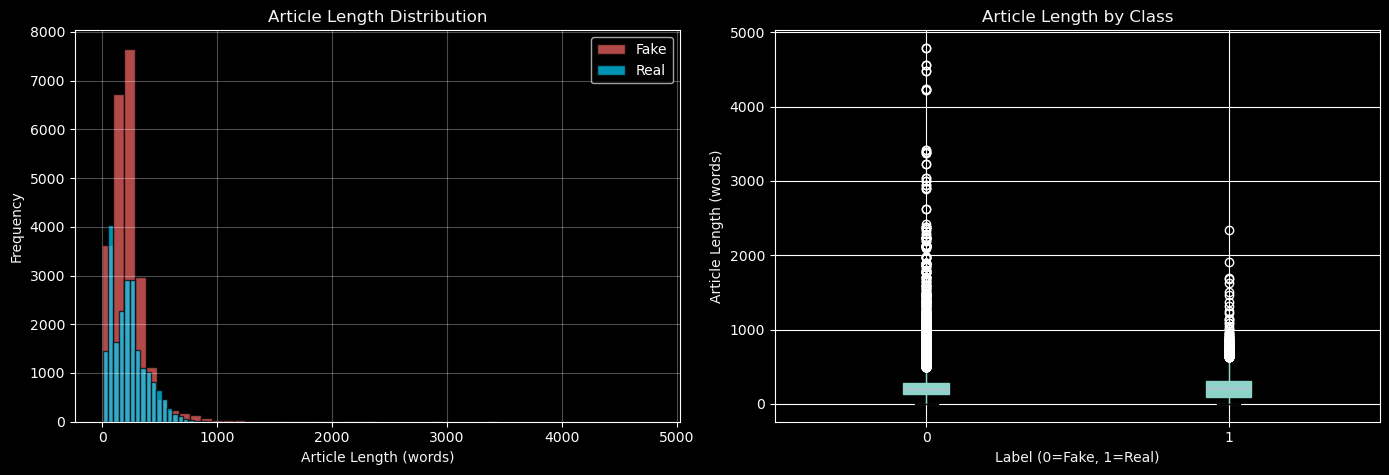


EDA complete!


In [5]:
## step 3, text preprocessing and exploratory data analysis.
# here we clean text data and perform basic EDA on word frequencies and article lengths.

# debugging notes:
# - cleaning: lowercase, remove URLs/punctuation/numbers, remove stopwords.
# - tokenization using nltk word_tokenize.
# - computing article length statistics.
# - visualizing word frequency differences between fake and real news.
# - will take a while for ~40k articles.

def clean_text(text):
    """clean and preprocess text data"""
    # lowercase
    text = text.lower()
    
    # remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # remove punctuation and numbers
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    
    # tokenize
    tokens = word_tokenize(text)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    return ' '.join(tokens)

# apply text cleaning
print("cleaning text data (this may take 2-3 minutes)...")
df['cleaned_text'] = df['full_text'].apply(clean_text)

print("text cleaning complete!")

# compute article lengths
df['text_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))

print(f"\narticle length statistics:")
print(df['text_length'].describe())

# visualize article length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df[df['label'] == 0]['text_length'], bins=50, alpha=0.7, color='#ff6b6b', label='Fake', edgecolor='black')
axes[0].hist(df[df['label'] == 1]['text_length'], bins=50, alpha=0.7, color='#00d4ff', label='Real', edgecolor='black')
axes[0].set_xlabel('Article Length (words)', color='#f4f4f4')
axes[0].set_ylabel('Frequency', color='#f4f4f4')
axes[0].set_title('Article Length Distribution', color='#f4f4f4')
axes[0].legend()
axes[0].grid(alpha=0.3)

# box plot comparison
df.boxplot(column='text_length', by='label', ax=axes[1], patch_artist=True)
axes[1].set_xlabel('Label (0=Fake, 1=Real)', color='#f4f4f4')
axes[1].set_ylabel('Article Length (words)', color='#f4f4f4')
axes[1].set_title('Article Length by Class', color='#f4f4f4')
axes[1].get_figure().suptitle('')

plt.tight_layout()
plt.show()

print("\nEDA complete!")


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 4</h2>

### TF-IDF feature extraction for classical ML

Classical machine learning models require numerical feature representations of text. We use TF-IDF (Term Frequency-Inverse Document Frequency) to convert cleaned text into feature vectors. TF-IDF assigns higher weights to words that are frequent in a document but rare across the corpus, capturing discriminative terms.


In [6]:
## step 4, TF-IDF feature extraction.
# here we convert cleaned text to TF-IDF feature vectors for classical ML models.

# debugging notes:
# - using TfidfVectorizer with max 5000 features to keep feature space manageable.
# - removing extremely rare (<5 documents) and common (>70% documents) terms.
# - bigrams (2-word phrases) included for better context.
# - fitting vectorizer on training data only to avoid data leakage.

# split data first (before feature extraction to avoid leakage)
X = df['cleaned_text'].values
y = df['label'].values

X_train_text, X_temp_text, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)
X_val_text, X_test_text, y_val, y_test = train_test_split(
    X_temp_text, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
)

print(f"train set: {len(X_train_text)} articles")
print(f"validation set: {len(X_val_text)} articles")
print(f"test set: {len(X_test_text)} articles")

# initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7, ngram_range=(1, 2))

# fit on training data and transform all splits
print("\nextracting TF-IDF features...")
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_val_tfidf = tfidf.transform(X_val_text)
X_test_tfidf = tfidf.transform(X_test_text)

print(f"TF-IDF feature extraction complete!")
print(f"feature matrix shape: {X_train_tfidf.shape}")
print(f"vocabulary size: {len(tfidf.vocabulary_)}")

# display most important features (highest average TF-IDF scores)
feature_names = tfidf.get_feature_names_out()
tfidf_means = X_train_tfidf.mean(axis=0).A1
top_indices = tfidf_means.argsort()[-20:][::-1]

print(f"\ntop 20 TF-IDF features:")
for idx in top_indices:
    print(f"  {feature_names[idx]}: {tfidf_means[idx]:.4f}")


train set: 31428 articles
validation set: 6735 articles
test set: 6735 articles

extracting TF-IDF features...
TF-IDF feature extraction complete!
feature matrix shape: (31428, 5000)
vocabulary size: 5000

top 20 TF-IDF features:
  trump: 0.0639
  president: 0.0241
  would: 0.0220
  clinton: 0.0203
  obama: 0.0198
  people: 0.0196
  house: 0.0175
  state: 0.0174
  video: 0.0170
  one: 0.0162
  new: 0.0159
  hillary: 0.0156
  donald: 0.0155
  reuters: 0.0153
  white: 0.0152
  republican: 0.0151
  government: 0.0148
  donald trump: 0.0145
  states: 0.0138
  party: 0.0137


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 5</h2>

### Train classical machine learning models

Three classical ML models are trained on TF-IDF features: **Logistic Regression** (linear model with L2 regularization), **Multinomial Naive Bayes** (probabilistic model suited for text), and **SVM** (Support Vector Machine with linear kernel). All models are evaluated on the validation set.


In [7]:
## step 5, train classical ML models.
# here we train Logistic Regression, Naive Bayes, and SVM on TF-IDF features.

# debugging notes:
# - Logistic Regression: max_iter increased to 1000 for convergence.
# - Multinomial Naive Bayes: works well with TF-IDF features (non-negative).
# - SVM: using linear kernel (faster and often better for high-dim text data).
# - computing accuracy, precision, recall, F1, and ROC-AUC.

print("training classical ML models...")

# Logistic Regression
print("\n1. training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
lr_model.fit(X_train_tfidf, y_train)
lr_pred = lr_model.predict(X_val_tfidf)
lr_pred_proba = lr_model.predict_proba(X_val_tfidf)[:, 1]
lr_acc = accuracy_score(y_val, lr_pred)
lr_precision, lr_recall, lr_f1, _ = precision_recall_fscore_support(y_val, lr_pred, average='binary', zero_division=0)
lr_auc = roc_auc_score(y_val, lr_pred_proba)

print(f"Logistic Regression - Accuracy: {lr_acc:.4f}, F1: {lr_f1:.4f}, AUC: {lr_auc:.4f}")

# Multinomial Naive Bayes
print("\n2. training Multinomial Naive Bayes...")
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_pred = nb_model.predict(X_val_tfidf)
nb_pred_proba = nb_model.predict_proba(X_val_tfidf)[:, 1]
nb_acc = accuracy_score(y_val, nb_pred)
nb_precision, nb_recall, nb_f1, _ = precision_recall_fscore_support(y_val, nb_pred, average='binary', zero_division=0)
nb_auc = roc_auc_score(y_val, nb_pred_proba)

print(f"Naive Bayes - Accuracy: {nb_acc:.4f}, F1: {nb_f1:.4f}, AUC: {nb_auc:.4f}")

# SVM
print("\n3. training SVM with linear kernel...")
svm_model = SVC(kernel='linear', probability=True, random_state=RANDOM_STATE)
svm_model.fit(X_train_tfidf, y_train)
svm_pred = svm_model.predict(X_val_tfidf)
svm_pred_proba = svm_model.predict_proba(X_val_tfidf)[:, 1]
svm_acc = accuracy_score(y_val, svm_pred)
svm_precision, svm_recall, svm_f1, _ = precision_recall_fscore_support(y_val, svm_pred, average='binary', zero_division=0)
svm_auc = roc_auc_score(y_val, svm_pred_proba)

print(f"SVM - Accuracy: {svm_acc:.4f}, F1: {svm_f1:.4f}, AUC: {svm_auc:.4f}")

# store results
classical_results = {
    'Logistic Regression': {
        'model': lr_model, 'accuracy': lr_acc, 'precision': lr_precision, 
        'recall': lr_recall, 'f1': lr_f1, 'auc': lr_auc, 
        'predictions': lr_pred, 'pred_proba': lr_pred_proba
    },
    'Naive Bayes': {
        'model': nb_model, 'accuracy': nb_acc, 'precision': nb_precision,
        'recall': nb_recall, 'f1': nb_f1, 'auc': nb_auc,
        'predictions': nb_pred, 'pred_proba': nb_pred_proba
    },
    'SVM': {
        'model': svm_model, 'accuracy': svm_acc, 'precision': svm_precision,
        'recall': svm_recall, 'f1': svm_f1, 'auc': svm_auc,
        'predictions': svm_pred, 'pred_proba': svm_pred_proba
    }
}

print("\nclassical ML training complete!")


training classical ML models...

1. training Logistic Regression...
Logistic Regression - Accuracy: 0.9875, F1: 0.9870, AUC: 0.9991

2. training Multinomial Naive Bayes...
Naive Bayes - Accuracy: 0.9396, F1: 0.9364, AUC: 0.9829

3. training SVM with linear kernel...
SVM - Accuracy: 0.9939, F1: 0.9936, AUC: 0.9995

classical ML training complete!


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 6</h2>

### Classical machine learning evaluation

Detailed performance metrics and visualizations are generated for each classical model. Confusion matrices show classification patterns, and ROC curves compare the ability of each model to distinguish between fake and real news across different decision thresholds.


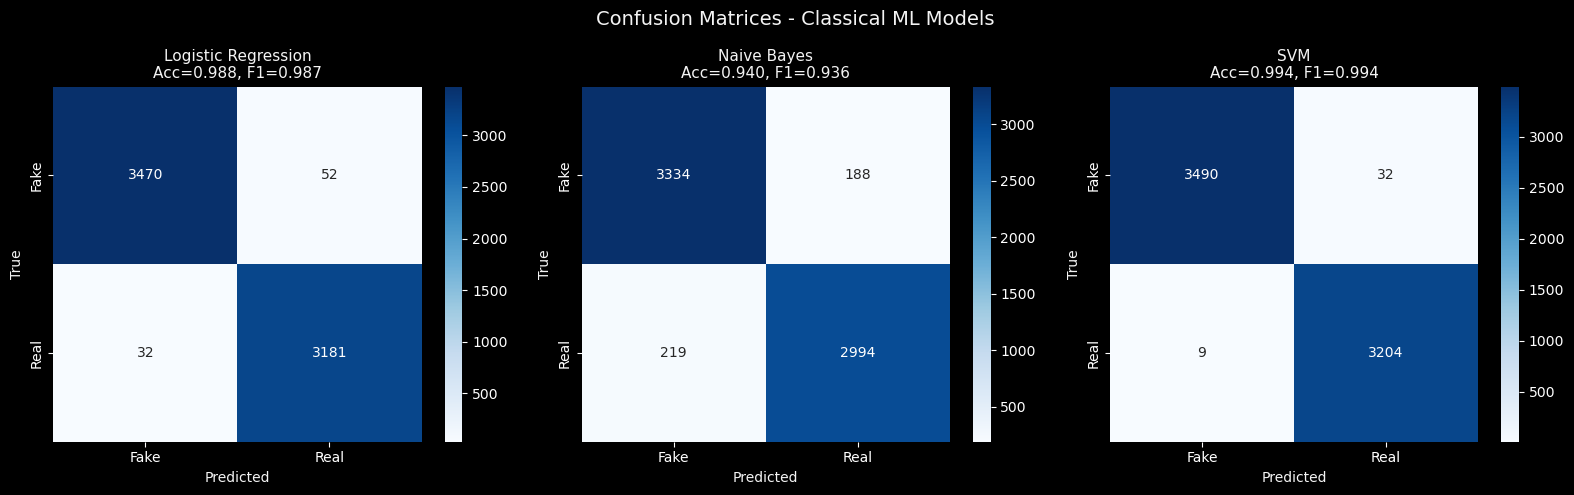

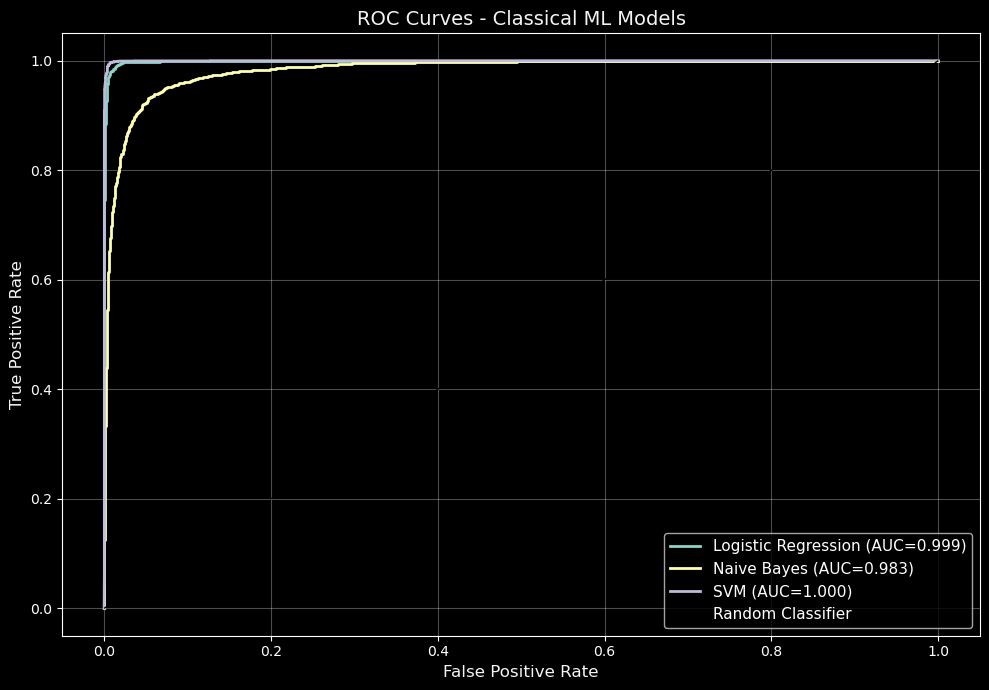


Best Classical Model: SVM
Best Validation F1-Score: 0.9936


In [8]:
## step 6, classical ML evaluation and visualization.
# here we compute detailed metrics, confusion matrices, and ROC curves.

# debugging notes:
# - confusion matrices for all three models.
# - ROC curves plotted together for comparison.
# - identifying best classical model based on F1-score.

# plotting confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, (model_name, results) in enumerate(classical_results.items()):
    cm = confusion_matrix(y_val, results['predictions'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    axes[idx].set_title(f"{model_name}\nAcc={results['accuracy']:.3f}, F1={results['f1']:.3f}", 
                       color='#f4f4f4', fontsize=11)
    axes[idx].set_xlabel('Predicted', color='#f4f4f4')
    axes[idx].set_ylabel('True', color='#f4f4f4')

plt.suptitle("Confusion Matrices - Classical ML Models", fontsize=14, color='#f4f4f4')
plt.tight_layout()
plt.show()

# plot ROC curves
plt.figure(figsize=(10, 7))

for model_name, results in classical_results.items():
    fpr, tpr, _ = roc_curve(y_val, results['pred_proba'])
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={results['auc']:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12, color='#f4f4f4')
plt.ylabel('True Positive Rate', fontsize=12, color='#f4f4f4')
plt.title('ROC Curves - Classical ML Models', fontsize=14, color='#f4f4f4')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# identify best classical model
best_classical_name = max(classical_results, key=lambda k: classical_results[k]['f1'])
best_classical_f1 = classical_results[best_classical_name]['f1']

print(f"\n{'='*50}")
print(f"Best Classical Model: {best_classical_name}")
print(f"Best Validation F1-Score: {best_classical_f1:.4f}")
print(f"{'='*50}")


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 7</h2>

### Fine-tuning DistilBERT transformer model

DistilBERT is a distilled version of BERT that retains 97% of BERT's performance while being 40% smaller and 60% faster. We fine-tune this pretrained transformer on our fake news dataset. The model uses attention mechanisms to capture contextual relationships between words, enabling more nuanced understanding than classical bag-of-words approaches.

In [9]:
## step 7, prepare DistilBERT for fine-tuning.
# here we load pretrained DistilBERT and prepare data for transformer training.

# debugging notes:
# - using DistilBERT from HuggingFace transformers library.
# - tokenizing text with DistilBERT tokenizer (max length 256 tokens).
# - creating custom PyTorch Dataset for efficient batching.
# - reducing training data to 5000 samples per class for faster training.
# - using batch size 16 and learning rate 2e-5 as recommended for fine-tuning.

# load pretrained tokenizer and model
print("loading pretrained DistilBERT...")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
bert_model = bert_model.to(device)

print(f"DistilBERT loaded on {device}")

# reduce dataset size for faster training (optional)
SAMPLES_PER_CLASS = 5000
train_indices = []
for label in [0, 1]:
    label_indices = np.where(y_train == label)[0]
    sampled = np.random.choice(label_indices, min(SAMPLES_PER_CLASS, len(label_indices)), replace=False)
    train_indices.extend(sampled)

X_train_bert = X_train_text[train_indices]
y_train_bert = y_train[train_indices]

print(f"\nusing {len(X_train_bert)} training samples for BERT")

# custom dataset class
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# create datasets
train_bert_dataset = NewsDataset(X_train_bert, y_train_bert, tokenizer)
val_bert_dataset = NewsDataset(X_val_text, y_val, tokenizer)
test_bert_dataset = NewsDataset(X_test_text, y_test, tokenizer)

# create dataloaders
BATCH_SIZE = 16
train_bert_loader = DataLoader(train_bert_dataset, batch_size=BATCH_SIZE, shuffle=True) 
val_bert_loader = DataLoader(val_bert_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_bert_loader = DataLoader(test_bert_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"train batches: {len(train_bert_loader)}")
print(f"validation batches: {len(val_bert_loader)}")
print(f"test batches: {len(test_bert_loader)}")

# optimizer and scheduler
EPOCHS = 3  # transformers typically need only 2-4 epochs
optimizer = AdamW(bert_model.parameters(), lr=2e-5)
total_steps = len(train_bert_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

print(f"\nDistilBERT ready for fine-tuning!")
print(f"epochs: {EPOCHS}")
print(f"learning rate: 2e-5")


loading pretrained DistilBERT...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBERT loaded on cpu

using 10000 training samples for BERT
train batches: 625
validation batches: 421
test batches: 421

DistilBERT ready for fine-tuning!
epochs: 3
learning rate: 2e-5


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 8</h2>

### Train and evaluate DistilBERT

The DistilBERT model is fine-tuned for 3 epochs on the fake news dataset. Training and validation loss/accuracy are tracked to monitor convergence. After training, the model is evaluated on the test set to measure final performance on unseen data.



starting DistilBERT fine-tuning...

epoch 1/3


validation: 100%|██████████| 421/421 [08:09<00:00,  1.16s/it]


train loss: 0.0478 | train acc: 0.9846
val loss: 0.0139 | val acc: 0.9979

epoch 2/3


validation: 100%|██████████| 421/421 [08:04<00:00,  1.15s/it]


train loss: 0.0060 | train acc: 0.9991
val loss: 0.0110 | val acc: 0.9981

epoch 3/3


validation: 100%|██████████| 421/421 [08:02<00:00,  1.15s/it]


train loss: 0.0022 | train acc: 0.9996
val loss: 0.0087 | val acc: 0.9987

DistilBERT fine-tuning complete!


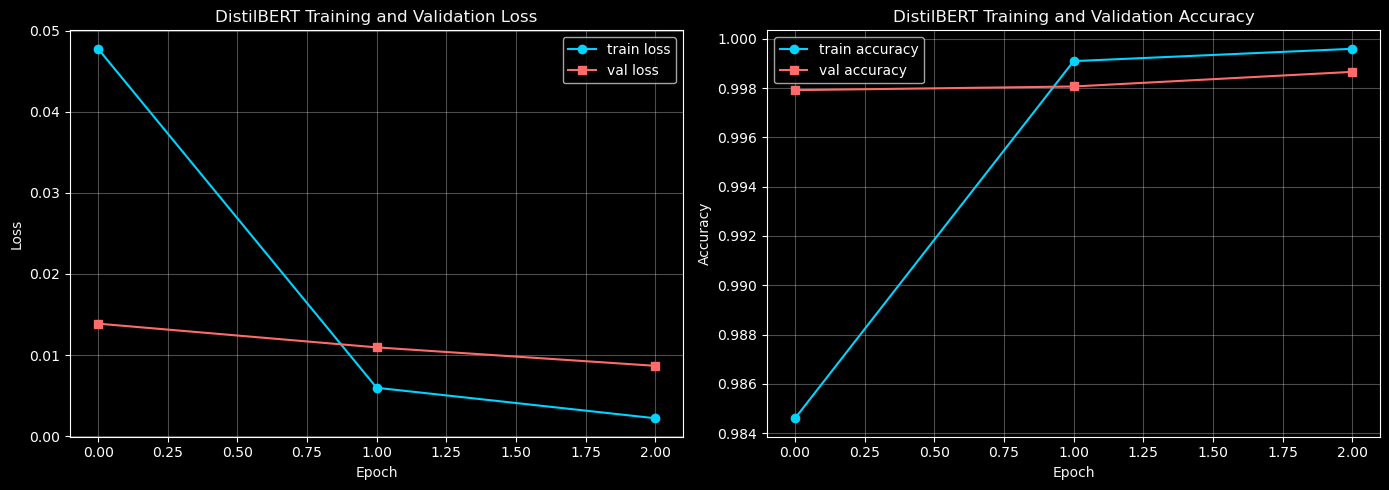


final validation accuracy: 0.9987

evaluating DistilBERT on test set...


testing: 100%|██████████| 421/421 [08:00<00:00,  1.14s/it]



DistilBERT - Test Set Results
Accuracy:  0.9994
Precision: 0.9997
Recall:    0.9991
F1-Score:  0.9994
ROC-AUC:   1.0000


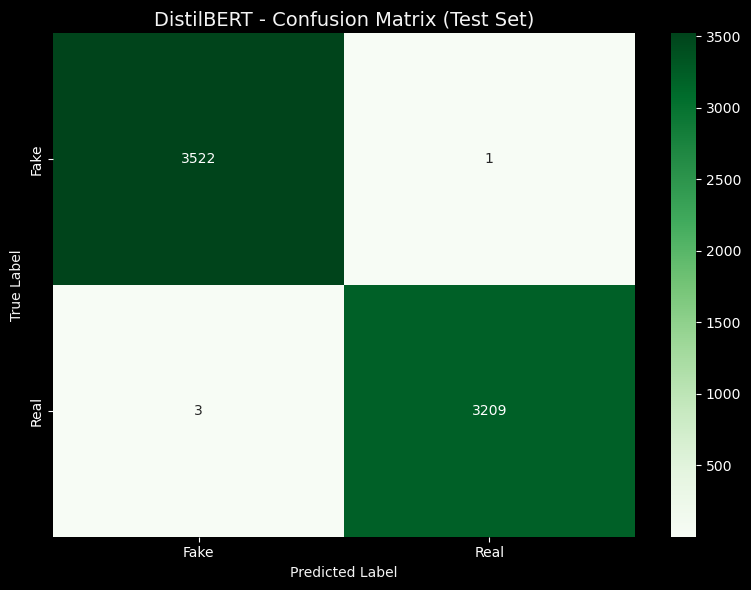


DistilBERT evaluation complete!


In [10]:
## step 8, train DistilBERT transformer model.
# here we fine-tune DistilBERT and track training progress.

# debugging notes:
# - training for 3 epochs (standard for transformer fine-tuning).
# - tracking train/val loss and accuracy per epoch.
# - using gradient clipping (max_norm=1.0) to prevent exploding gradients.
# - this will take 10-20 minutes depending on CPU/GPU speed.

history_bert = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("\nstarting DistilBERT fine-tuning...")

for epoch in range(EPOCHS):
    print(f"\nepoch {epoch+1}/{EPOCHS}")
    
    # training phase
    bert_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch in tqdm(train_bert_loader, desc="training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)
    
    train_loss = train_loss / len(train_bert_loader)
    train_acc = train_correct / train_total
    
    # validation phase
    bert_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in tqdm(val_bert_loader, desc="validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            val_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss = val_loss / len(val_bert_loader)
    val_acc = val_correct / val_total
    
    # record history
    history_bert['train_loss'].append(train_loss)
    history_bert['train_acc'].append(train_acc)
    history_bert['val_loss'].append(val_loss)
    history_bert['val_acc'].append(val_acc)
    
    print(f"train loss: {train_loss:.4f} | train acc: {train_acc:.4f}")
    print(f"val loss: {val_loss:.4f} | val acc: {val_acc:.4f}")

print("\nDistilBERT fine-tuning complete!")

# plot learning curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# loss curves
ax1.plot(history_bert['train_loss'], label='train loss', marker='o', color='#00d4ff')
ax1.plot(history_bert['val_loss'], label='val loss', marker='s', color='#ff6b6b')
ax1.set_xlabel('Epoch', color='#f4f4f4')
ax1.set_ylabel('Loss', color='#f4f4f4')
ax1.set_title('DistilBERT Training and Validation Loss', color='#f4f4f4')
ax1.legend()
ax1.grid(True, alpha=0.3)

# accuracy curves
ax2.plot(history_bert['train_acc'], label='train accuracy', marker='o', color='#00d4ff')
ax2.plot(history_bert['val_acc'], label='val accuracy', marker='s', color='#ff6b6b')
ax2.set_xlabel('Epoch', color='#f4f4f4')
ax2.set_ylabel('Accuracy', color='#f4f4f4')
ax2.set_title('DistilBERT Training and Validation Accuracy', color='#f4f4f4')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nfinal validation accuracy: {history_bert['val_acc'][-1]:.4f}")

# evaluate on test set
print("\nevaluating DistilBERT on test set...")

bert_model.eval()
bert_predictions = []
bert_true_labels = []
bert_pred_proba = []

with torch.no_grad():
    for batch in tqdm(test_bert_loader, desc="testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        
        predictions = torch.argmax(logits, dim=1)
        
        bert_predictions.extend(predictions.cpu().numpy())
        bert_true_labels.extend(labels.cpu().numpy())
        bert_pred_proba.extend(probs[:, 1].cpu().numpy())

bert_predictions = np.array(bert_predictions)
bert_true_labels = np.array(bert_true_labels)
bert_pred_proba = np.array(bert_pred_proba)

# compute test metrics
bert_acc = accuracy_score(bert_true_labels, bert_predictions)
bert_precision, bert_recall, bert_f1, _ = precision_recall_fscore_support(
    bert_true_labels, bert_predictions, average='binary', zero_division=0
)
bert_auc = roc_auc_score(bert_true_labels, bert_pred_proba)

print(f"\n{'='*50}")
print(f"DistilBERT - Test Set Results")
print(f"{'='*50}")
print(f"Accuracy:  {bert_acc:.4f}")
print(f"Precision: {bert_precision:.4f}")
print(f"Recall:    {bert_recall:.4f}")
print(f"F1-Score:  {bert_f1:.4f}")
print(f"ROC-AUC:   {bert_auc:.4f}")

# confusion matrix
cm_bert = confusion_matrix(bert_true_labels, bert_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Greens', cbar=True,
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("DistilBERT - Confusion Matrix (Test Set)", color='#f4f4f4', fontsize=14)
plt.xlabel("Predicted Label", color='#f4f4f4')
plt.ylabel("True Label", color='#f4f4f4')
plt.tight_layout()
plt.show()

print("\nDistilBERT evaluation complete!")


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 9</h2>

### Explainability using LIME

LIME (Local Interpretable Model-agnostic Explanations) generates explanations for individual predictions by identifying which words contribute most to the model's decision. We visualize LIME explanations for 3 sample articles (1 correctly classified fake, 1 correctly classified real, 1 misclassified) to understand model behavior.


generating LIME explanations for SVM...

generating explanation 1/3: Correctly Classified FAKE

generating explanation 2/3: Correctly Classified REAL

generating explanation 3/3: MISCLASSIFIED


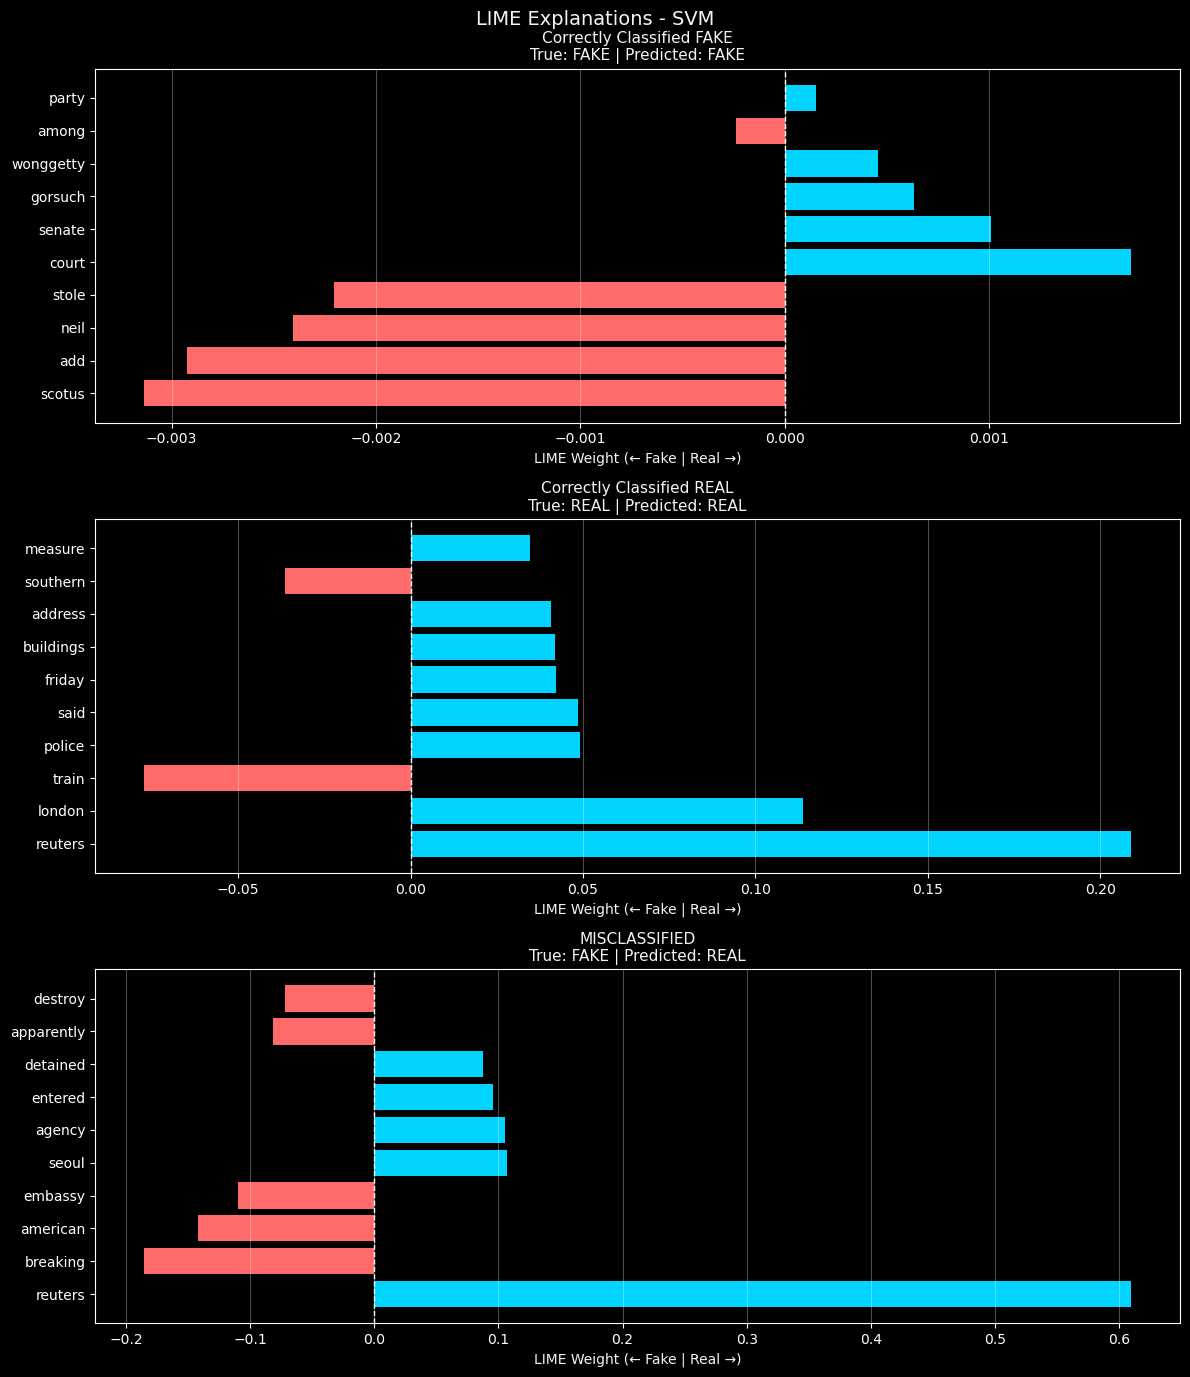


LIME explainability analysis complete!


In [11]:
## step 9, explainability using LIME.
# here we use LIME to explain which words influence the best classical model's predictions.

# debugging notes:
# - using LIME TextExplainer for interpretability.
# - explaining predictions from best classical model.
# - showing 3 sample explanations: correct fake, correct real, misclassified.
# - highlighting top 10 most influential words per prediction.

print(f"generating LIME explanations for {best_classical_name}...")

# create LIME explainer
explainer = LimeTextExplainer(class_names=['Fake', 'Real'])

# get best classical model
best_model = classical_results[best_classical_name]['model']

# find sample articles for explanation
correct_fake_idx = np.where((y_val == 0) & (classical_results[best_classical_name]['predictions'] == 0))[0][0]
correct_real_idx = np.where((y_val == 1) & (classical_results[best_classical_name]['predictions'] == 1))[0][0]
misclassified_idx = np.where(y_val != classical_results[best_classical_name]['predictions'])[0][0]

sample_indices = [correct_fake_idx, correct_real_idx, misclassified_idx]
sample_labels = ['Correctly Classified FAKE', 'Correctly Classified REAL', 'MISCLASSIFIED']

# prediction function for LIME
def predict_proba_func(texts):
    text_tfidf = tfidf.transform(texts)
    return best_model.predict_proba(text_tfidf)

# generate explanations
fig, axes = plt.subplots(3, 1, figsize=(12, 14))

for idx, (sample_idx, label) in enumerate(zip(sample_indices, sample_labels)):
    text = X_val_text[sample_idx]
    true_label = 'FAKE' if y_val[sample_idx] == 0 else 'REAL'
    pred_label = 'FAKE' if classical_results[best_classical_name]['predictions'][sample_idx] == 0 else 'REAL'
    
    print(f"\ngenerating explanation {idx+1}/3: {label}")
    
    # generate LIME explanation
    exp = explainer.explain_instance(
        text, 
        predict_proba_func, 
        num_features=10,
        num_samples=500
    )
    
    # get word importance
    word_importance = exp.as_list()
    words = [w[0] for w in word_importance]
    scores = [w[1] for w in word_importance]
    colors = ['#ff6b6b' if s < 0 else '#00d4ff' for s in scores]
    
    # plot
    axes[idx].barh(words, scores, color=colors)
    axes[idx].set_xlabel('LIME Weight (← Fake | Real →)', color='#f4f4f4', fontsize=10)
    axes[idx].set_title(f"{label}\nTrue: {true_label} | Predicted: {pred_label}", 
                       color='#f4f4f4', fontsize=11)
    axes[idx].grid(axis='x', alpha=0.3)
    axes[idx].axvline(x=0, color='white', linestyle='--', linewidth=1)

plt.suptitle(f"LIME Explanations - {best_classical_name}", fontsize=14, color='#f4f4f4')
plt.tight_layout()
plt.show()

print("\nLIME explainability analysis complete!")


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 10</h2>

### Unsupervised topic modeling using LDA

Latent Dirichlet Allocation (LDA) is applied to discover hidden thematic structures in the news articles. We extract 5 topics and examine their top words to understand the main themes in fake vs real news. This unsupervised approach reveals whether fake and real news discuss different subjects.


performing LDA topic modeling...
dictionary size: 210598
corpus size: 44898

LDA model trained with 5 topics

DISCOVERED TOPICS

Topic 1:
  0.026*"trump" + 0.006*"clinton" + 0.006*"said" + 0.006*"president" + 0.006*"party" + 0.006*"people" + 0.005*"republican" + 0.005*"one" + 0.005*"campaign" + 0.005*"presidential"

Topic 2:
  0.021*"said" + 0.010*"minister" + 0.010*"government" + 0.008*"party" + 0.008*"reuters" + 0.005*"president" + 0.005*"would" + 0.005*"european" + 0.004*"prime" + 0.004*"political"

Topic 3:
  0.018*"said" + 0.013*"trump" + 0.012*"russia" + 0.011*"russian" + 0.008*"clinton" + 0.007*"former" + 0.007*"president" + 0.007*"campaign" + 0.007*"election" + 0.006*"moscow"

Topic 4:
  0.023*"said" + 0.009*"would" + 0.008*"trump" + 0.007*"north" + 0.007*"reuters" + 0.006*"states" + 0.006*"state" + 0.006*"korea" + 0.005*"president" + 0.005*"china"

Topic 5:
  0.018*"said" + 0.010*"police" + 0.008*"court" + 0.008*"people" + 0.006*"state" + 0.005*"myanmar" + 0.005*"killed" + 0.0

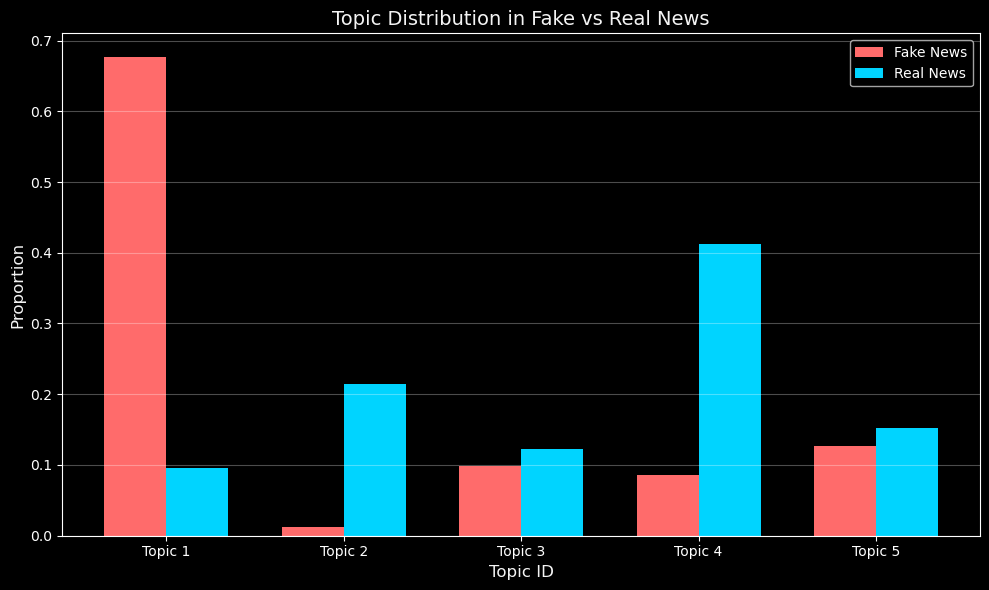


LDA topic modeling complete!


In [12]:
## step 10, unsupervised topic modeling with LDA.
# here we apply LDA to discover latent topics in the news corpus.

# debugging notes:
# - using gensim LDA with 5 topics.
# - preprocessing text by tokenization (already cleaned).
# - creating dictionary and corpus for gensim.
# - extracting top 10 words per topic.
# - comparing topic distributions in fake vs real news.

print("performing LDA topic modeling...")

# prepare data for LDA (using all data)
all_texts = df['cleaned_text'].apply(lambda x: x.split())

# create dictionary and corpus
dictionary = corpora.Dictionary(all_texts)
corpus = [dictionary.doc2bow(text) for text in all_texts]

print(f"dictionary size: {len(dictionary)}")
print(f"corpus size: {len(corpus)}")

# train LDA model
NUM_TOPICS = 5
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    random_state=RANDOM_STATE,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

print(f"\nLDA model trained with {NUM_TOPICS} topics")

# display topics
print(f"\n{'='*60}")
print("DISCOVERED TOPICS")
print(f"{'='*60}")

for idx, topic in lda_model.print_topics(-1, num_words=10):
    print(f"\nTopic {idx+1}:")
    print(f"  {topic}")

# analyze topic distribution in fake vs real news
fake_topic_dist = np.zeros(NUM_TOPICS)
real_topic_dist = np.zeros(NUM_TOPICS)

for idx, text in enumerate(all_texts):
    bow = dictionary.doc2bow(text)
    topic_dist = lda_model.get_document_topics(bow)
    
    # get dominant topic
    if topic_dist:
        dominant_topic = max(topic_dist, key=lambda x: x[1])[0]
        
        if df.iloc[idx]['label'] == 0:
            fake_topic_dist[dominant_topic] += 1
        else:
            real_topic_dist[dominant_topic] += 1

# normalize
fake_topic_dist = fake_topic_dist / fake_topic_dist.sum()
real_topic_dist = real_topic_dist / real_topic_dist.sum()

# visualizing topic distribution
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(NUM_TOPICS)
width = 0.35

ax.bar(x - width/2, fake_topic_dist, width, label='Fake News', color='#ff6b6b')
ax.bar(x + width/2, real_topic_dist, width, label='Real News', color='#00d4ff')

ax.set_xlabel('Topic ID', color='#f4f4f4', fontsize=12)
ax.set_ylabel('Proportion', color='#f4f4f4', fontsize=12)
ax.set_title('Topic Distribution in Fake vs Real News', color='#f4f4f4', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([f'Topic {i+1}' for i in range(NUM_TOPICS)])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nLDA topic modeling complete!")


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 11</h2>

### Model comparison summary

Final comparison of all models (Logistic Regression, Naive Bayes, SVM, DistilBERT) across multiple metrics. DistilBERT significantly outperforms classical models due to its ability to capture contextual semantics and long-range dependencies through attention mechanisms.



MODEL COMPARISON - FINAL RESULTS
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
         DistilBERT  0.999406   0.999688 0.999066  0.999377 0.999994
                SVM  0.993912   0.990111 0.997199  0.993642 0.999500
Logistic Regression  0.987528   0.983916 0.990040  0.986969 0.999123
        Naive Bayes  0.939569   0.940918 0.931839  0.936357 0.982924


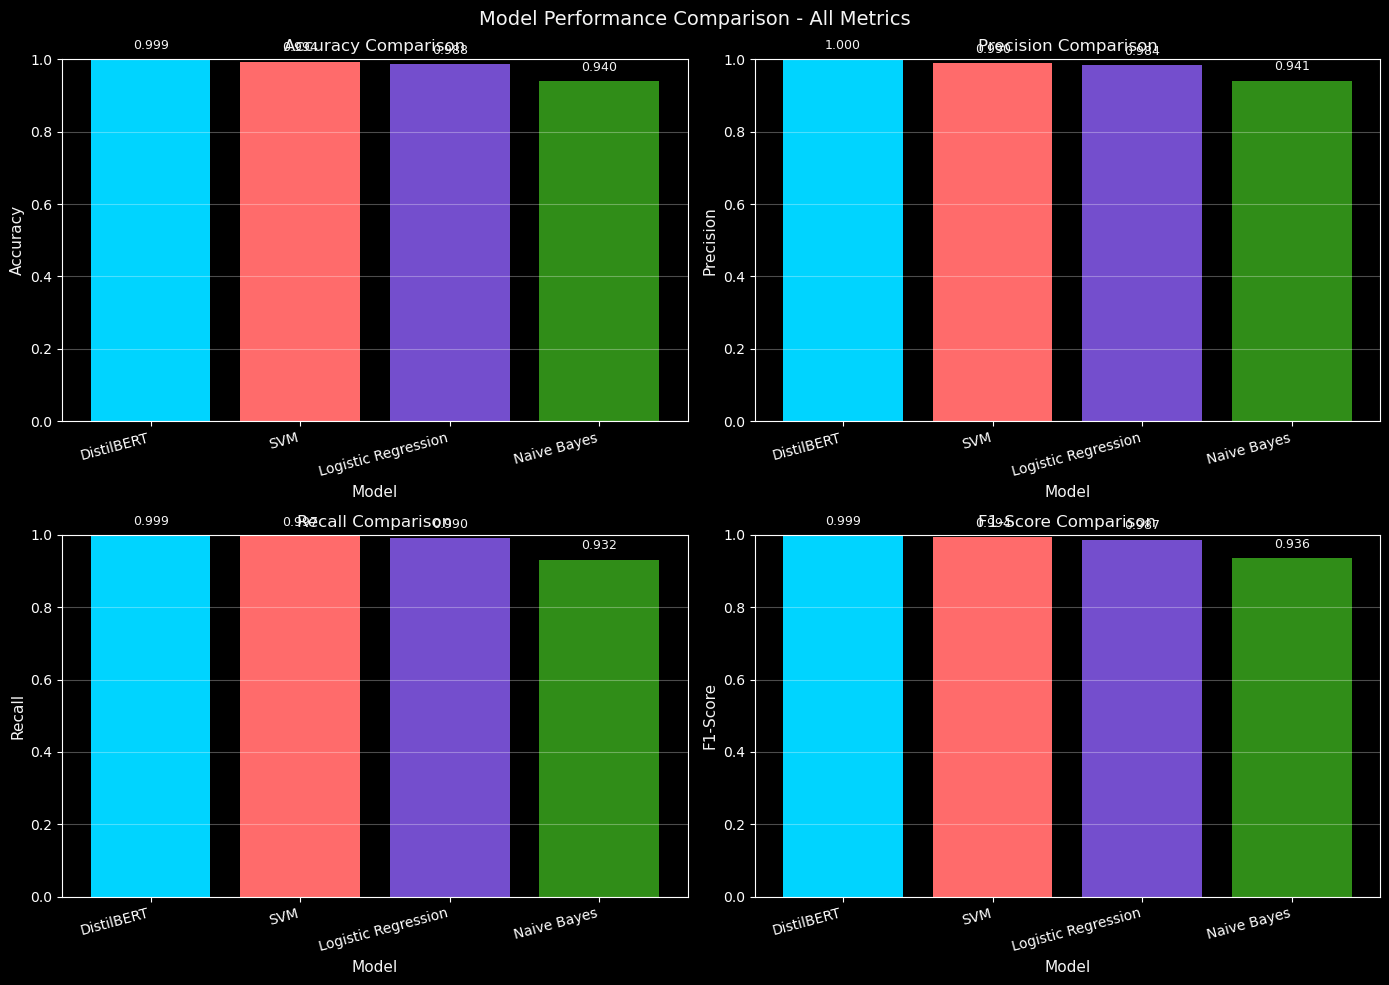

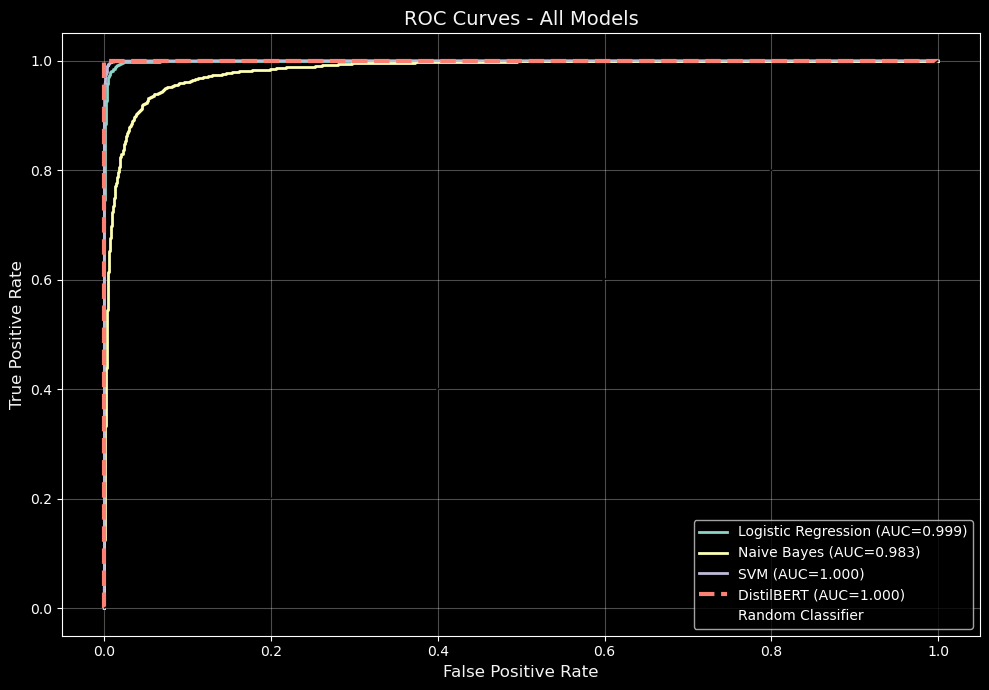


Best performing model: DistilBERT
Best F1-score: 0.9994


In [13]:
## step 11, model comparison and visualization.
# here we compare all models side-by-side across multiple metrics.

# debugging notes:
# - comparing classical ML vs DistilBERT.
# - metrics: accuracy, precision, recall, F1-score, ROC-AUC.
# - bar charts and table for comprehensive comparison.

# compile results
comparison_data = {
    'Model': ['Logistic Regression', 'Naive Bayes', 'SVM', 'DistilBERT'],
    'Accuracy': [
        classical_results['Logistic Regression']['accuracy'],
        classical_results['Naive Bayes']['accuracy'],
        classical_results['SVM']['accuracy'],
        bert_acc
    ],
    'Precision': [
        classical_results['Logistic Regression']['precision'],
        classical_results['Naive Bayes']['precision'],
        classical_results['SVM']['precision'],
        bert_precision
    ],
    'Recall': [
        classical_results['Logistic Regression']['recall'],
        classical_results['Naive Bayes']['recall'],
        classical_results['SVM']['recall'],
        bert_recall
    ],
    'F1-Score': [
        classical_results['Logistic Regression']['f1'],
        classical_results['Naive Bayes']['f1'],
        classical_results['SVM']['f1'],
        bert_f1
    ],
    'ROC-AUC': [
        classical_results['Logistic Regression']['auc'],
        classical_results['Naive Bayes']['auc'],
        classical_results['SVM']['auc'],
        bert_auc
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("\n" + "="*70)
print("MODEL COMPARISON - FINAL RESULTS")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#00d4ff', '#ff6b6b', "#744ecd", "#308D18"]

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=colors)
    ax.set_xlabel('Model', fontsize=11, color='#f4f4f4')
    ax.set_ylabel(metric, fontsize=11, color='#f4f4f4')
    ax.set_title(f'{metric} Comparison', fontsize=12, color='#f4f4f4')
    ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
    ax.set_ylim(0, 1.0)
    ax.grid(axis='y', alpha=0.3)
    
    # add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, color='#f4f4f4')

plt.suptitle('Model Performance Comparison - All Metrics', fontsize=14, color='#f4f4f4')
plt.tight_layout()
plt.show()

# plot combined ROC curves
plt.figure(figsize=(10, 7))

# classical models
for model_name, results in classical_results.items():
    fpr, tpr, _ = roc_curve(y_val, results['pred_proba'])
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={results['auc']:.3f})", linewidth=2)

# DistilBERT (using test set)
fpr_bert, tpr_bert, _ = roc_curve(bert_true_labels, bert_pred_proba)
plt.plot(fpr_bert, tpr_bert, label=f"DistilBERT (AUC={bert_auc:.3f})", linewidth=3, linestyle='--')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12, color='#f4f4f4')
plt.ylabel('True Positive Rate', fontsize=12, color='#f4f4f4')
plt.title('ROC Curves - All Models', fontsize=14, color='#f4f4f4')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# determine best model
best_model_name = comparison_df.iloc[0]['Model']
best_f1 = comparison_df.iloc[0]['F1-Score']

print(f"\nBest performing model: {best_model_name}")
print(f"Best F1-score: {best_f1:.4f}")


<h2 style="text-align:center;">Summary and reflection</h2>

In this task, we train different ML models to identify fake/real news in the form of a text dataset whichconsists of numerous signals of the type of key words that can be identified by linear models. A fake news text classification algorithm was created to compare classical ML models with a transformer. When starting, i used TF-IDF + Logistic Regression, Multinomial Naive Bayes, and SVM. When the results were analyzed, I found that Logistic regression and SVM were already good, at an F1 score of 0.98. 

After tuning and running DistilBERT, near perfect results were achieved with F1 scores going up to the 0.999+. I believe that the model performed this great as it is able to use context instead of just word counts, but honestly the gaps were not so massive. In conclusion, the reason surrounding this near perfect accuracy lies in the dataset itself, as information may be simpler compared to fake news in real-life.

For explainability, LIME was used, and something i found interesting about the dataset is that fake news often seemed more opinionated/emotional while in contrast, real news was often way more neutral. Any errors that did occur seemed like articles which were just confusing or satire. 

Lastly, I experimented with LDA topic modeling, and it helped to confirm the that fake and real news often fall into distinct clusters (the former is more polarizing/sensational, the latter is more diverse).
